In [53]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import esutil, scipy
sys.path.append('../')
sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/')
from utils import *
from cmass_modules import io, Cuts
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
def z_gaussian(mu, sigma, bins):
    return 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))

def z_gaussians(A, bins):

    sigma1 = 0.07
    sigma2 = 0.2
    mu1 = 0.59
    mu2 = 0.35
    g1 = 1./(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu1)**2 / (2 * sigma1**2))
    g2 = 1./(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu2)**2 / (2 * sigma2**2))
    
    return A*g1 + (1.0-A) * g2

In [3]:
def log_interp(x, y):
    """
    Log interpolation
    """
    s = scipy.interpolate.interp1d(log(x), log(y))
    x0 = x[0]
    y0 = y[0]
    x1 = x[-1]
    y1 = y[-1]

    def interpolator(xi):
        w1 = xi == 0
        w2 = (xi > 0) & (xi <= x0)
        w3 = xi >= x1
        w4 = ~ (w1 | w2 | w3)

        y = np.zeros_like(xi)
        y[w2] = y0 * (x0 / xi[w2])
        y[w3] = y1 * (x1 / xi[w3])**3
        y[w4] = exp(s(log(xi[w4])))
        return y
    return interpolator

def interp_2d( x, y, z):
    f = scipy.interpolate.interp2d(x, y, z, kind='cubic')
    return f

def cl_to_w(ell, c_ell, theta):
    """
    Fourier transform
    # theta unit : degree
    """
    theta = np.radians(theta)
    cl_interp = log_interp(ell, c_ell)
    ell_max = int(ell.max())
    ell_max_integral = 200000
    ell_sample = np.arange(ell_max_integral) * 1.0
    c_ell_sample = np.zeros(ell_max_integral)
    c_ell_sample = cl_interp(ell_sample)
#    for i,ell_i in enumerate(ell_sample):
#        c_ell_sample[i] = cl_interp(ell_i)

    f = (2 * ell_sample + 1) / (4 * pi)
    w = np.zeros_like(theta)
    for i, t in enumerate(theta):
        p_ell, _ = scipy.special.lpn(ell_max_integral - 1, cos(t))
        w[i] = (f * p_ell * c_ell_sample).sum()
    return w

In [4]:
#Nz_cmass = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/cmass_sgc.nz_2')
#Nz_cmass = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/dmass_ansatz_a0.07.nz')
#N_wise = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/gama_wise_common.nz')



In [5]:
#zbin,dz = np.linspace(0.0,10., 1001, retstep=True)
#zcenter = zbin[:-1]+dz/2.
#Nz = np.column_stack(( zbin[:-1], N1, N2, N3, N4 ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/twomass.nz', Nz)
#Nz = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/twomass.nz')
#Nz_cmass,_ = np.histogram( cmass_spec['Z'], bins=zbin, normed=True)
#Nz_cmass = np.column_stack(( zbin[:-1], Nz_cmass ))


def Pnz(z, i, Nzdata):
    from scipy.interpolate import interp1d
    zbin = Nzdata[:,0]
    nz = Nzdata[:,1]
    dz =  Nzdata[:,0][1] -  Nzdata[:,0][0]
    zcenter = zbin + dz/2.
    #zcenter = np.insert( zbin + dz/2., 0, 0)
    #nz = np.insert( Nz[:, i], 0, 0)
    pnz = interp1d(zcenter, nz)
    return pnz(z)

#def Pnz_wise_1bin(z, i, Nzdata):
#    from scipy.interpolate import interp1d
#    zcenter = np.insert( N_2mass_all[:,0] + 0.005, 0, 0)
#    nz = np.insert( N_2mass_all[:, 1], 0, 0)
#    pnz = interp1d(zcenter, nz)
#    return pnz(z)


#def Pnz_cmass(z, i):
#    from scipy.interpolate import interp1d
#    zcenter = np.insert( Nz_cmass[:,0] + 0.005, 0, 0)
#    nz = np.insert( Nz_cmass[:, 1], 0, 0)
#    pnz = interp1d(zcenter, nz)
#    return pnz(z)


In [6]:
from numpy import log, exp, cos, pi

def chi(a):
    return results.comoving_radial_distance(1./a -1.)/coverH0 * h0

def Ea(a):
    return results.hubble_parameter(1./a - 1.) * 1./pars.H0

def b_cmass(z):
    bc = np.zeros(z.size)
    bc[z < 0.4] = 1.6
    bc[(z>=0.4) & (z < 0.45)] = 1.9
    bc[z >= 0.4] = 2.0
    return bc
    

def dchi_da(a):
    return 1./Ea(a)/a**2

def Pdelta(k, a):
    k = k/coverH0
    return PK.P(1./a -1., k)/(coverH0)**3

def int_for_Cl(ell, a, indz):
    
    k =  (ell+0.5) *1./chi(a)
    Pm =  np.array([Pdelta(k[i], a[i]) for i in range(k.size)])
    return Wgal_2mass(a,indz) * Wgal_2mass(a,indz) * dchi_da(a)/chi(a)**2 * Pm
 
def C_ell( ell, indz ):
    
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
        
    Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return Cl


def w_matter(theta, a):
    
    ellbin = np.logspace(np.log10(1e-2), np.log10(100000), 400)
    
    k =  (ellbin+0.5) *1./chi(a)
    Pm = Pdelta(k,a)
    
    w = cl_to_w(ellbin, Pm, theta)
    return w


def w_matter_interp(theta):
    
    zmin = 0.0001
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 50, retstep = True)
    #acenter = abin[:-1] + da/2.
           
    wprojt = np.array([w_matter(theta, a) for a in abin])
    wprojt_interp = interp_2d(theta, abin, wprojt)
    return wprojt_interp
    
    

def w_project_1bin( theta, w_matter_interp, Nzdata1=None, Nzdata2=None, b1=2.0, b2=1.5927021517080193):
    """
    w(theta). 
    Default kernel is cmass_kernel * 2mass_kernel 1bin
    """
    
    #Nz_cmass = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/cmass_sgc.nz_2')
    #Nz_cmass = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/zdistris/dmass_ansatz_a0.07.nz')
    #N_wise = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/gama_wise_common.nz')



    from scipy.integrate import simps 
    zmin = 0.02
    zmax = 0.98    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
    
    wprojt = w_matter_interp(theta, acenter)  #np.array([w_matter(theta, a) for a in acenter])
    
    
    z = 1./acenter -1.
    #b_cmass(z)
    Wgal1 = b1 * Pnz(1./acenter -1., 1, Nzdata1) * Ea(acenter)
    
    #b_avg_tot = 1.5927021517080193
    wgal2  = b2 * Pnz(1./acenter -1., 1, Nzdata2) * Ea(acenter)

    int_for_res = Wgal1 * wgal2 * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)





#def dw(a, indz):
#    return Wgal_2mass(a, indz)* Wgal_cmass(a, indz) *dchi_da(a)/chi(a)**2 * w_matter(theta, a)

In [7]:


def Hartrap_factor(Nr, Nbin):
    return (Nr-Nbin-2) *1./(Nr-1)



In [8]:
def BOSSveto(cat, option='SGC'):
    
    import fitsio
    if option == 'SGC':
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits')
    elif option == 'NGC': 
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits')

    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=4096, nest= False)
    HPmask = np.in1d(hpind, valid_hpind)
    
    return cat[HPmask]

# WISE true redshift

### Calling WISE Extended source catalog

In [14]:
wise = esutil.io.read('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.fits', upper=True)

In [15]:
wise = BOSSveto(wise, option='NGC')
#cont_mask = moon_cont_mask(wise)
#wise = wise[cont_mask]

### GAMA-WISE catalog

In [18]:
from fitsio import FITS
gama_wise = FITS('/n/des/lee.5922/data/gama_cat/GAMA-WISECat.fits')
gama_spec = FITS('/n/des/lee.5922/data/gama_cat/SpecObj.fits')

gama_id1 = gama_wise[1]['CATAID'].read()
gama_id2 = gama_spec[1]['CATAID'].read()
print gama_id1.size, gama_id2.size
#gama_obj_mask =np.in1d( gama_id2, gama_id1 )


m_gw, m_spec = esutil.numpy_util.match(gama_id1, gama_id2)

#ra = gama_spec[1]['RA'].read()[ramask]
#dec = gama_spec[1]['DEC'].read()[ramask]

ra_gw = gama_wise[1]['RA'].read()[m_gw]
dec_gw = gama_wise[1]['DEC'].read()[m_gw]
redshift = gama_spec[1]['Z'].read()[m_spec]

#desig = gama_wise[1]['DESIG_ALLWISE'].read()[m_gw]

print ra_gw.size

import esutil
h = esutil.htm.HTM(10)
m_gw, m_wise, _ = h.match( ra_gw, dec_gw, wise['RA'], wise['DEC'], 3./3600, maxmatch=1)
#m_gw, m_wise = esutil.numpy_util.match( desig , wise_ngc['DESIGNATION'])

redshift_common = redshift[m_gw]
wise_ngc_common = wise[m_wise]

print m_wise.size

197262 160026
114897
10402


In [27]:
gama_ra = gama_wise[1]['RA'].read()
gama_dec = gama_wise[1]['DEC'].read()

hpind = hpRaDecToHEALPixel(gama_ra, gama_dec, nside=256)
wise_hpind = hpRaDecToHEALPixel(wise['RA'], wise['DEC'], nside=256)
hpmask = np.in1d(wise_hpind,  hpind)
print np.sum(hpmask)
print m_wise.size*1./np.sum(hpmask) * 100, '%'

12804
81.2402374258 %


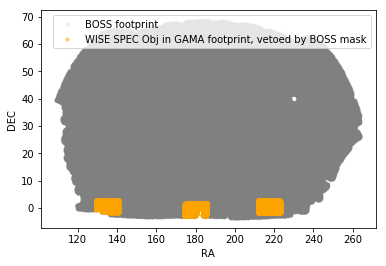

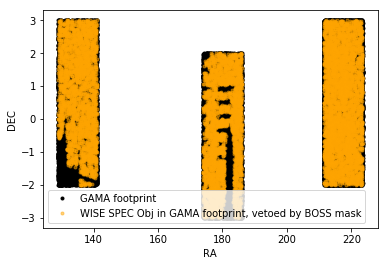

In [47]:
fig, ax = plt.subplots()

ax.plot(wise['RA'], wise['DEC'], '.', label='BOSS footprint', color='grey', alpha = 0.1)
#ax.plot(ra_gw, dec_gw, '.', color = 'black', label='GAMA footprint')
ax.plot(wise_ngc_common['RA'], wise_ngc_common['DEC'], '.', label = 'WISE SPEC Obj in GAMA footprint, vetoed by BOSS mask', color = 'orange', alpha = 0.5)


#ax.plot(wise['RA'][hpmask], wise['DEC'][hpmask], '.', label='WISE in GAMA footprint', alpha = 0.5)
#ax.plot(wise_ngc_common['RA'], wise_ngc_common['DEC'], '.', label = 'WISE SPEC Obj in GAMA footprint, vetoed by BOSS mask', color = 'orange', alpha = 0.5)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.legend()

fig, ax = plt.subplots()

#ax.plot(wise['RA'], wise['DEC'], '.', label='BOSS footprint', color='grey', alpha = 0.5)
ax.plot(ra_gw, dec_gw, '.', color = 'black', label='GAMA footprint')
#ax.plot(wise['RA'][hpmask], wise['DEC'][hpmask], '.', label='WISE in GAMA footprint', alpha = 0.5)
ax.plot(wise_ngc_common['RA'], wise_ngc_common['DEC'], '.', label = 'WISE SPEC Obj in GAMA footprint, vetoed by BOSS mask', color = 'orange', alpha = 0.5)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.legend()

In [69]:
bins

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [82]:
bins.size, Nz_gamma_wise.size

(51, 50)

bin size= 0.02


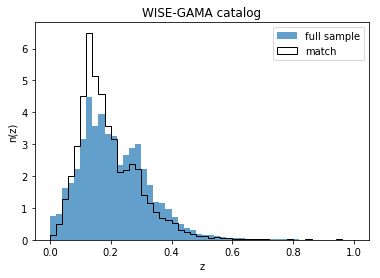

In [87]:
fig, ax = plt.subplots()
bins = np.linspace(0,1,51)
Nz_gamma_wise, _ ,_= ax.hist( redshift, bins=bins, normed=True, alpha=0.7, label='full sample' )
#ax.hist( gama_spec[1]['Z'].read(), bins=bins, normed=True, histtype='step', label='gamma' )
Nz_gamma_wise_common, _, _ = ax.hist( redshift_common, bins=bins, normed=True, color='k', histtype='step' , label='match'  )

ax.set_title('WISE-GAMA catalog')
ax.set_xlabel('z')
ax.set_ylabel('n(z)')
ax.legend()
#ax.text(0.7, 1, '81% has specz')

print 'bin size=', bins[1]-bins[0]

#DAT = np.column_stack((bins[:-1], Nz_gamma_wise ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/gama_wise_full.nz', DAT)

#DAT = np.column_stack((bins[:-1], Nz_gamma_wise_common ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/gama_wise_common.nz', DAT)

In [79]:
ls /n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/

u'/n/des/lee.5922/Dropbox/repositories/CMASS/code/notebook'

In [9]:
import camb
from camb import model, initialpower

In [12]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.7, ombh2=0.0221, omch2 =0.1169, omk=0.0, YHe = 0.245341, tau = 0.08,
                   num_massive_neutrinos = 1)
pars.set_dark_energy()
pars.InitPower.set_params(As=2.1e-9, ns=0.96)
results = camb.get_results(pars)

#units
cc = 299792.5
H0 = 100 
coverH0 = cc/H0
h0 = pars.H0/100.

# matter power spectrum interpolation
PK = camb.get_matter_power_interpolator\
(pars, zmin=0, zmax=10, nz_step = 101, nonlinear=True, 
 hubble_units=True, k_hunit=True, kmax=1000, log_interp = True)
    

### cmass vs 2mass forecast

In [16]:
theta = np.logspace(np.log10(0.5/60), np.log10(300./60), 100, endpoint=True)
theta_cen = theta[:-1]*np.sqrt(theta[1]/theta[0])

In [14]:
w_matter_2d_interp = w_matter_interp(theta_cen)

In [15]:
Nz_cmass_sgc = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/cmass_sgc.nz_2')
Nz_cmass_full = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/cmass_full.nz')
N_wise = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/gama_wise_common.nz')


b_sgc = 2.03
b_full = 2.06
b_wise = 1.06
wproj_sgc = w_project_1bin(theta_cen, w_matter_2d_interp, Nzdata1 = Nz_cmass_sgc, Nzdata2=N_wise, b1=b_sgc, b2=b_wise)
wproj_full = w_project_1bin(theta_cen, w_matter_2d_interp, Nzdata1 = Nz_cmass_full, Nzdata2=N_wise, b1=b_full, b2=b_wise)


import scipy
wproj_sgc_interp = scipy.interpolate.interp1d( theta_cen, wproj_sgc)
wproj_full_interp = scipy.interpolate.interp1d( theta_cen, wproj_full)


In [21]:
DAT = np.column_stack(( theta_cen, wproj_sgc ))
np.savetxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/wise/theory_wise_cmass_sgc.txt', DAT)

DAT = np.column_stack(( theta_cen, wproj_full ))
np.savetxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/wise/theory_wise_cmass_full.txt', DAT)

In [109]:
basedir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/'

#DAT = np.loadtxt(basedir+'acf_cross_wise_x_dmass_weight_nbins10_jk100.txt')
#meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

#DAT = np.loadtxt(basedir+'acf_cross_wise_x_dmass_weight_pcut01_nbins10_jk100_no2.txt')
#DAT = np.loadtxt(basedir+'acf_cross_wise_x_dmass_weight_pcut01_nbins10_jk100_no2.txt')
#meanr2, xi2, _ = [DAT[:,i] for i in range(3)]
cov_dmass = np.loadtxt(basedir+'acf_cross_wise_x_dmass_weight_pcut01_nbins10_jk100_no2.cov') #*1./HFactor
xi_err2 = np.sqrt(cov_dmass.diagonal())

#DAT = np.loadtxt(basedir +'acf_cross_wise_x_cmass_full_sys_cp_nz_weight_nbins10_jk100_no2.txt')
#DAT = np.loadtxt(basedir +'acf_cross_wise_x_cmass_ngc_nbins10_binslop05_jk100.txt')
#meanr3, xi3, _ = [DAT[:,i] for i in range(3)]
cov_cmass_ngc = np.loadtxt(basedir +'acf_cross_wise_x_cmass_ngc_nbins10_binslop05_jk100.cov') #*1./HFactor
xi_err3 = np.sqrt(cov_cmass_ngc.diagonal())

#../data_txt/acf_cross_wise_x_cmass_sgc_no4.txt
#DAT = np.loadtxt(basedir+'acf_cross_wise_x_cmass_sgc_sys_cp_nz_weight_nbins10_jk100_no2.txt')
#cov_cmass_sgc = np.loadtxt(basedir +'acf_cross_wise_x_cmass_sgc_sys_cp_nz_weight_nbins10_jk100_no2.cov') #*1./HFactor
cov_cmass_sgc = np.genfromtxt(basedir+'acf_cross_wise_x_cmass_sgc_nbins10_binslop05_jk100.cov')
#meanr4, xi4, _ = [DAT[:,i] for i in range(3)]
xi_err4 = np.sqrt(cov_cmass_sgc.diagonal())

#cov_cmass_sgc = np.loadtxt('../data_txt/acf_cross_wise_x_cmass_sgc_no4.cov')

#DAT2 = np.loadtxt('data_txt/acf_cross_wise_x_cmass_sgc.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

F_cmass_sgc = np.linalg.inv(cov_cmass_sgc)
F_cmass_ngc = np.linalg.inv(cov_cmass_ngc)
cov_cmass_full = np.linalg.inv(F_cmass_sgc + F_cmass_ngc )

In [98]:

cov_cmass_sgc_jk100 = np.genfromtxt('../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act//\
acf_cross_wise_x_cmass_sgc_nbins10_binslop05_jk100.cov')

In [99]:
actdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/'
_, rmean_sgc, _, xi_sgc, sigma_xi_sgc, DD_sgc,_,_,_,_ = \
np.genfromtxt(actdir+'npairs_cross_wise_x_cmass_sgc_nbins10_binslop05.txt',unpack=True)
_, rmean_ngc, _, xi_ngc, sigma_xi_ngc, DD_ngc,_,_,_,_ = \
np.genfromtxt(actdir+'npairs_cross_wise_x_cmass_ngc_nbins10_binslop05.txt',unpack=True)
_, rmean_dmass, _, xi_dmass, sigma_xi_dmass, DD_dmass,_,_,_,_ = \
np.genfromtxt(actdir+'npairs_cross_wise_x_dmass_nbins10_binslop05.txt',unpack=True)

In [64]:
cov_cmass_sgc_analytic_filename = '/n/des/lee.5922/programs/cosmolike/lighthouse_cov/output_cross_wise/\
cov_cross_wise_cmass_sgc_10bins_NG_llll_cov_Ntheta10_Ntomo1_1'
cov_cmass_ngc_analytic_filename = '/n/des/lee.5922/programs/cosmolike/lighthouse_cov/output_cross_wise/\
cov_cross_wise_cmass_ngc_10bins_NG_llll_cov_Ntheta10_Ntomo1_1'
cov_dmass_analytic_filename = '/n/des/lee.5922/programs/cosmolike/lighthouse_cov/output_cross_wise/\
cov_cross_wise_dmass_10bins_NG_llll_cov_Ntheta10_Ntomo1_1'

In [80]:
from su_utils import read_cov
cov_cmass_sgc_analytic = read_cov( covfilename = cov_cmass_sgc_analytic_filename, NG=True)[-10:, -10:]
cov_cmass_ngc_analytic = read_cov( covfilename = cov_cmass_ngc_analytic_filename, NG=True)[-10:, -10:]
cov_dmass_analytic = read_cov( covfilename = cov_dmass_analytic_filename, NG=True)[-10:, -10:]

F_sgc = np.linalg.inv(cov_cmass_sgc_analytic)
F_ngc = np.linalg.inv(cov_cmass_ngc_analytic)
cov_cmass_full_analytic = np.linalg.inv( F_sgc + F_ngc  )

In [60]:
cov_cmass_sgc_analytic_filename = '/n/des/lee.5922/programs/cosmolike/lighthouse_cov/output_cross_wise/\
cov_cross_wise_cmass_sgc_10bins_G_shotnoise_llll_cov_Ntheta10_Ntomo1_1'
cov_cmass_ngc_analytic_filename = '/n/des/lee.5922/programs/cosmolike/lighthouse_cov/output_cross_wise/\
cov_cross_wise_cmass_ngc_10bins_G_shotnoise_llll_cov_Ntheta10_Ntomo1_1'
cov_dmass_analytic_filename = '/n/des/lee.5922/programs/cosmolike/lighthouse_cov/output_cross_wise/\
cov_cross_wise_dmass_10bins_G_shotnoise_llll_cov_Ntheta10_Ntomo1_1'

cov_cmass_sgc_analytic_shotnoise = read_cov( covfilename = cov_cmass_sgc_analytic_filename, NG=False)[-10:, -10:]
cov_cmass_ngc_analytic_shotnoise = read_cov( covfilename = cov_cmass_ngc_analytic_filename, NG=False)[-10:, -10:]
cov_dmass_analytic_shotnoise = read_cov( covfilename = cov_dmass_analytic_filename, NG=False)[-10:, -10:]

In [50]:
HF = Hartrap_factor(100, 10)

0.888888888889


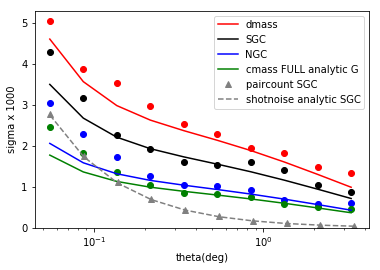

In [112]:

fig, ax = plt.subplots()

#ax.plot(meanr4, 1000*np.sqrt(cov_cmass.diagonal()), 'k--', label='jk' )
#ax.plot(meanr4, 1000*np.sqrt(cov_cmass_full.diagonal()), '--', label='full jk' )
ax.plot(meanr4, 1000*np.sqrt(cov_dmass.diagonal()), 'ro')#, label='dmass jk' )
ax.plot(meanr4, 1000*np.sqrt(cov_cmass_sgc.diagonal()), 'ko')#, label='SGC jk' )
ax.plot(meanr4, 1000*np.sqrt(cov_cmass_ngc.diagonal()), 'bo' )#, label='NGC jk' )
ax.plot(meanr4, 1000*np.sqrt(cov_cmass_full.diagonal()), 'go' )#, label='NGC jk' )




#ax.plot(meanr4, 1000*np.sqrt(cov_cmass_sgc_analytic_NG.diagonal()), 'k-', label='cmass sgc analytic NG' )

ax.plot(meanr4, 1000*np.sqrt(cov_dmass_analytic.diagonal()), 'r-', label='dmass' )
ax.plot(meanr4, 1000*np.sqrt(cov_cmass_sgc_analytic.diagonal()), 'k-', label='SGC' )
ax.plot(meanr4, 1000*np.sqrt(cov_cmass_ngc_analytic.diagonal()), 'b-', label='NGC' )
ax.plot(meanr4, 1000*np.sqrt(cov_cmass_full_analytic.diagonal()), 'g-', label='cmass FULL analytic G' )

ax.plot(rmean_sgc, 1000*np.sqrt(1./DD_sgc), '^', color='grey', label='paircount SGC')
ax.plot(rmean_sgc, 1000*np.sqrt(cov_cmass_sgc_analytic_shotnoise.diagonal()), '--', color='grey', label='shotnoise analytic SGC')

ax.set_ylim(0,)
ax.set_xscale('log')

ax.set_ylabel('sigma x 1000')
ax.set_xlabel('theta(deg)')

ax.legend()

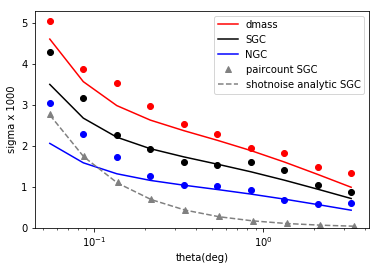

In [108]:

fig, ax = plt.subplots()

#ax.plot(meanr4, 1000*np.sqrt(cov_cmass.diagonal()), 'k--', label='jk' )
#ax.plot(meanr4, 1000*np.sqrt(cov_cmass_full.diagonal()), '--', label='full jk' )
ax.plot(meanr4, 1000*np.sqrt(cov_dmass.diagonal()), 'ro')#, label='dmass jk' )
ax.plot(meanr4, 1000*np.sqrt(cov_cmass_sgc.diagonal()), 'ko')#, label='SGC jk' )
ax.plot(meanr4, 1000*np.sqrt(cov_cmass_ngc.diagonal()), 'bo' )#, label='NGC jk' )




#ax.plot(meanr4, 1000*np.sqrt(cov_cmass_sgc_analytic_NG.diagonal()), 'k-', label='cmass sgc analytic NG' )

ax.plot(meanr4, 1000*np.sqrt(cov_dmass_analytic.diagonal()), 'r-', label='dmass' )
ax.plot(meanr4, 1000*np.sqrt(cov_cmass_sgc_analytic.diagonal()), 'k-', label='SGC' )
ax.plot(meanr4, 1000*np.sqrt(cov_cmass_ngc_analytic.diagonal()), 'b-', label='NGC' )
#ax.plot(meanr4, 1000*np.sqrt(cov_cmass_full_analytic.diagonal()), 'g-', label='cmass FULL analytic G' )

ax.plot(rmean_sgc, 1000*np.sqrt(1./DD_sgc), '^', color='grey', label='paircount SGC')
ax.plot(rmean_sgc, 1000*np.sqrt(cov_cmass_sgc_analytic_shotnoise.diagonal()), '--', color='grey', label='shotnoise analytic SGC')

ax.set_ylim(0,)
ax.set_xscale('log')

ax.set_ylabel('sigma x 1000')
ax.set_xlabel('theta(deg)')

ax.legend()

sgc  = 7.632149841190184
full = 21.840299092406195
dmass= 10.198893798540846


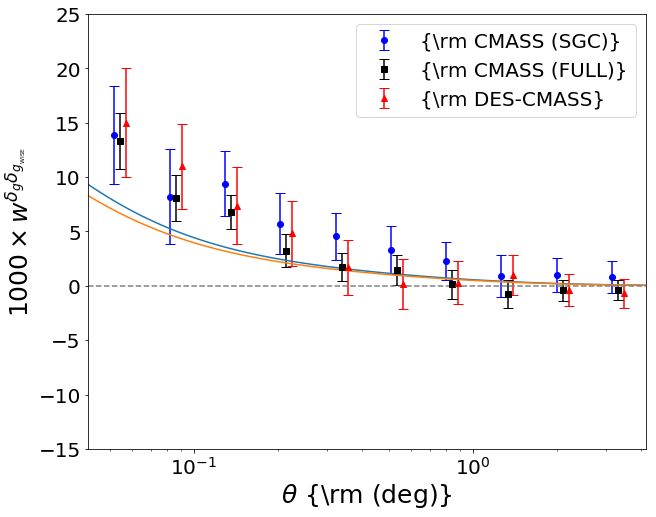

In [19]:



fig, ax = plt.subplots(figsize = (10, 8))
#ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '-b', label='WISE x dmass')

#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr4*0.95, 1000*xi4, yerr = 1000*xi_err4, fmt = 'o', color = 'b', capsize = 5, label=r'{\rm CMASS (SGC)}')
ax.errorbar(meanr3*1.0, 1000*xi3, yerr = 1000*xi_err3, fmt = 's', color = 'k', capsize = 5, label=r'{\rm CMASS (FULL)}')
ax.errorbar(meanr2*1.05, 1000*xi2, yerr = 1000*xi_err2, fmt = '^', color = 'r', capsize = 5, label=r'{\rm DES-CMASS}')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='WISE x cmass(sgc)')

ax.plot(theta_cen, 1000*wproj_sgc)
ax.plot(theta_cen, 1000*wproj_full)

#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
#chisqr = np.sum( (xi4-xi3)**2/xi_err3**2 )*1./xi3.size

chisqr = np.dot(np.dot(wproj_sgc_interp(meanr4)-xi4, np.linalg.inv(cov_cmass)), wproj_sgc_interp(meanr4)-xi4)
chisqr_full = np.dot(np.dot(wproj_full_interp(meanr3)-xi3, np.linalg.inv(cov_cmass_full)), wproj_full_interp(meanr3)-xi3)

chisqr_dmass = np.dot(np.dot(wproj_sgc_interp(meanr4)-xi2, np.linalg.inv(cov_dmass)), wproj_sgc_interp(meanr2)-xi2)
print 'sgc  =', chisqr
print 'full =',chisqr_full
print 'dmass=',chisqr_dmass

#chisqr2 = np.dot(np.dot(xi2-xi4, np.linalg.inv(cov_dmass + cov_cmass)), xi2-xi4)# *1./xi2.size # np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
#chisqr3 = np.dot(np.dot(xi2-xi3, np.linalg.inv(cov_dmass + cov_cmass_full)), xi2-xi3)# *1./xi3.size
#print chisqr2, chisqr3

#ax.text(0.25, -9, r'$\chi^2/{\rm dof}~(\rm CMASS~SGC)$'+r'$~=~{:0.3f}/10$'.format(chisqr2), fontsize = 20)
#ax.text(0.25, -11.5, r'$\chi^2/{\rm dof}~(\rm CMASS~FULL)$'+r'$~=~{:0.3f}/10$'.format(chisqr3), fontsize = 20)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 20)
#ax.text(1.5, 0.07, r'$\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.set_ylim(-15, 25)
ax.set_xlim(2.5/60, 250/60.)
ax.set_xlabel(r'$\theta$ {\rm (deg)}', fontsize = 25)
ax.set_ylabel(r'$1000 \times w^{ \delta_{g} \delta_{g_{\rm _{WISE}}}} ~(\theta)$', fontsize = 25)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')
ax.tick_params(labelsize=20)
#fig.savefig('../paper_figure//acf_wise.pdf' )

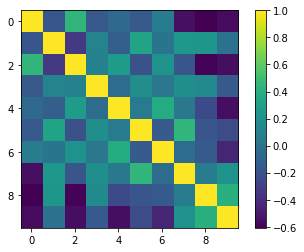

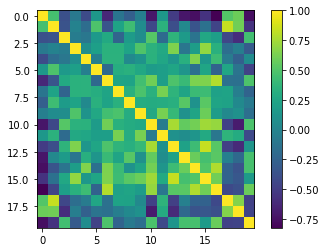

In [208]:
fig, ax = plt.subplots()
im = ax.imshow( np.corrcoef(cov) )
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
im = ax.imshow( np.corrcoef(cov2) )
fig.colorbar(im, ax=ax)

In [50]:
ls ../data_txt/acf_cross_2mass_x_cmass_sgc_sys_cp_noz_weight_no_bweight_nbins10_jk100.txt

../data_txt/acf_cross_2mass_x_cmass_sgc_sys_cp_noz_weight_no_bweight_nbins10_jk100.txt
